# Classification between Cracked, and Non-Cracked Images. 

### -----------------------------------------------------------------------------------------------------------------------------------------

##  Contents:


### 1. Introduction
### 2. Upload the Data and Unzip it
### 3. Install necessary libraries
### 4. Import important libraries
### 5. Create dataset 
### 6. Data Visualization
### 7. Create the Model
### 8. Perform Classification with the trained model
### 9. Misclassified Data

### 1.0 : Introduction:-






I am using a concrete dataset with positive and negative images, positive means images with cracks on the wall and negative means otherwise.I will be using a  pre-trained model called  ResNet18. ResNet-18 is a convolutional neural network that is 18 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.


### 2.0 : Upload the Data and Unzip it

In [0]:
# To upload the Concrete Data with Positive Tensors 

!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
!unzip -q Positive_tensors.zip 

--2020-06-14 12:10:59--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

100%[====================================>] 2,598,656,062 47.2MB/s   in 50s    

2020-06-14 12:11:50 (49.3 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [0]:
# To upload the Concrete Data with Negative Tensors 

! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2020-06-14 12:15:10--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

100%[====================================>] 2,111,408,108 47.1MB/s   in 43s    

2020-06-14 12:15:54 (46.8 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



### 3.0 : Install necessary libraries


In [0]:
!pip install torchvision

     |████████████████████████████████| 6.6MB 6.0MB/s eta 0:00:01
     |████████████████████████████████| 752.0MB 16kB/s s eta 0:00:01    |█                               | 24.1MB 31.1MB/s eta 0:00:24██▊                         | 157.7MB 29.7MB/s eta 0:00:21/s eta 0:00:14MB/s eta 0:00:07��██████████████▏   | 661.4MB 25.5MB/s eta 0:00:04     |█████████████████████████████▉  | 700.1MB 35.9MB/s eta 0:00:02


In [0]:
!pip install torchsummary

### 4.0 : Import important libraries


In [0]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os
import torch

### 5.0 : Create dataset 


In [0]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
            print('Number of images in Training Dataset :-',len(self.all_files))
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
            print('Number of images in Validation Dataset :-',len(self.all_files))

       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


#### 5.1 : Split the dataset into Training and Validating Datasets. 

In [0]:
# Training Data
train_dataset = Dataset(train=True)

Number of images in Training Dataset :- 30000


In [0]:
# Validating Data
validation_dataset = Dataset(train=False)

Number of images in Validation Dataset :- 10000


### 6.0 : Data Visualization
#### 6.1 : Function to visualize the data


In [0]:
def visualize(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(224, 224, 3))
    plt.title('y = ' + str(data_sample[1].item()))

#### 6.2 : Visualizing the data before classification 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


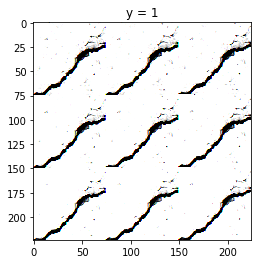

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


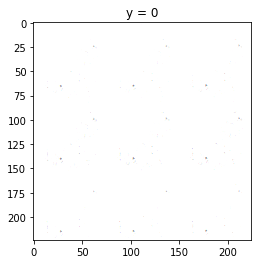

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


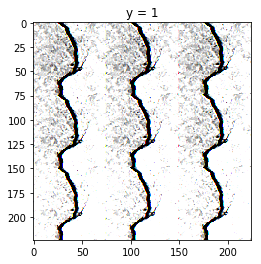

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


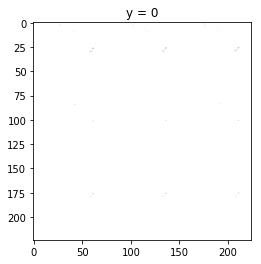

In [0]:
#Visualizing the first four images in training dataset
for i, (x, y) in enumerate(train_dataset):
    if i<4:
        visualize(train_dataset[i])
        plt.show()
    else:
        break
# I have titled every image with either 0 or 1
# 0 :- Non-cracked image
# 1 :- Cracked image 

### 7.0 : Create the Model


#### 7.1 : Importing the ResNet18 model and setting the parameter pre-trained and progress to True  


In [0]:
import torchvision.models as models
model = models.resnet18(pretrained=True,progress=True)

#### 7.2 : Setting the attribute requires_grad to False. As a result, the parameters will not be affected by training.


In [0]:
for param in model.parameters():
    param.requires_grad = False   

#### 7.3 : Replacing the output layer model.fc of the neural network with a nn.Linear object, to classify 2 different classes.


In [0]:
model.fc = nn.Linear(512, 2)

#### 7.4 :  Summary of our ResNet18 model.


In [0]:
from torchsummary import summary
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]          36,864
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
       BasicBlock-11           [-1, 64, 57, 57]               0
           Conv2d-12           [-1, 64, 57, 57]          36,864
      BatchNorm2d-13           [-1, 64, 57, 57]             128
             ReLU-14           [-1, 64,

### 8.0 : Perform Classification with the trained model


#### 8.1 : Create the loss function


In [0]:
criterion = nn.CrossEntropyLoss()

#### 8.2 : Creating a training loader and validation loader object,with the batch size equal to 100 samples each.


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

#### 8.3 : Used Adam optimizer to minimise the loss


In [0]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

#### 8.4 : Running the model on the dataset

In [0]:
import time
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs
j=1
i=1
k=0
Loss=0
start_time = time.time()

for epoch in range(n_epochs):
    
    print('TRAINING PHASE')
    print('*************************************************************')
    for x, y in train_loader:
        print('Loop Number:-',i,'/300')
        t = time.time()
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z = model(x)
        # calculate loss 
        loss = criterion(z, y)
        # calculate gradients of parameters 
        #loss_sublist.append(loss.data.item())
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
        print(loss.data)
        k=k+1
        i=i+1
        print("Finished this iteration of training phase in {} (s)".format(time.time()-t))
        print('-------------------------------------------------------------------')

        
    print('VALIDATION PHASE')
    print('*************************************************************')
    correct=0
    for x_test, y_test in validation_loader:
        print("Loop Number:-",j,'/100')
        t = time.time()
        # set model to eval 
        model.eval()
        #make a prediction 
        z = model(x_test)
        #find max 
        _, yhat = torch.max(z.data, 1)

        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat==y_test).sum().item()
        j=j+1
        print()
        print("Finished this iteration of validation phase in {} (s)".format(time.time()-t))
        print('-------------------------------------------------------------------')
    print('*************************************************************')
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

TRAINING PHASE
*************************************************************
Loop Number:- 1 /300
tensor(0.8291)
Finished this iteration of training phase in 6.303781270980835 (s)
-------------------------------------------------------------------
Loop Number:- 2 /300
tensor(0.7977)
Finished this iteration of training phase in 6.134464502334595 (s)
-------------------------------------------------------------------
Loop Number:- 3 /300
tensor(0.7564)
Finished this iteration of training phase in 6.067509889602661 (s)
-------------------------------------------------------------------
Loop Number:- 4 /300
tensor(0.7070)
Finished this iteration of training phase in 6.2400126457214355 (s)
-------------------------------------------------------------------
Loop Number:- 5 /300
tensor(0.6198)
Finished this iteration of training phase in 6.110935688018799 (s)
-------------------------------------------------------------------
Loop Number:- 6 /300
tensor(0.6133)
Finished this iteration of trai

Loop Number:- 49 /300
tensor(0.1138)
Finished this iteration of training phase in 6.186440467834473 (s)
-------------------------------------------------------------------
Loop Number:- 50 /300
tensor(0.1036)
Finished this iteration of training phase in 6.262513160705566 (s)
-------------------------------------------------------------------
Loop Number:- 51 /300
tensor(0.0981)
Finished this iteration of training phase in 6.165907621383667 (s)
-------------------------------------------------------------------
Loop Number:- 52 /300
tensor(0.1063)
Finished this iteration of training phase in 6.3105292320251465 (s)
-------------------------------------------------------------------
Loop Number:- 53 /300
tensor(0.0902)
Finished this iteration of training phase in 6.170705318450928 (s)
-------------------------------------------------------------------
Loop Number:- 54 /300
tensor(0.0954)
Finished this iteration of training phase in 6.28913688659668 (s)
------------------------------------

Loop Number:- 97 /300
tensor(0.0622)
Finished this iteration of training phase in 6.3535802364349365 (s)
-------------------------------------------------------------------
Loop Number:- 98 /300
tensor(0.0644)
Finished this iteration of training phase in 6.231672525405884 (s)
-------------------------------------------------------------------
Loop Number:- 99 /300
tensor(0.0807)
Finished this iteration of training phase in 6.1655237674713135 (s)
-------------------------------------------------------------------
Loop Number:- 100 /300
tensor(0.0548)
Finished this iteration of training phase in 6.1912078857421875 (s)
-------------------------------------------------------------------
Loop Number:- 101 /300
tensor(0.0748)
Finished this iteration of training phase in 6.214661598205566 (s)
-------------------------------------------------------------------
Loop Number:- 102 /300
tensor(0.0549)
Finished this iteration of training phase in 6.163971662521362 (s)
------------------------------

Loop Number:- 145 /300
tensor(0.0603)
Finished this iteration of training phase in 6.207852602005005 (s)
-------------------------------------------------------------------
Loop Number:- 146 /300
tensor(0.0399)
Finished this iteration of training phase in 6.108564376831055 (s)
-------------------------------------------------------------------
Loop Number:- 147 /300
tensor(0.0495)
Finished this iteration of training phase in 6.327088832855225 (s)
-------------------------------------------------------------------
Loop Number:- 148 /300
tensor(0.0389)
Finished this iteration of training phase in 6.245441675186157 (s)
-------------------------------------------------------------------
Loop Number:- 149 /300
tensor(0.0430)
Finished this iteration of training phase in 6.192745685577393 (s)
-------------------------------------------------------------------
Loop Number:- 150 /300
tensor(0.0628)
Finished this iteration of training phase in 6.192838907241821 (s)
------------------------------

Loop Number:- 193 /300
tensor(0.0227)
Finished this iteration of training phase in 6.17158842086792 (s)
-------------------------------------------------------------------
Loop Number:- 194 /300
tensor(0.0400)
Finished this iteration of training phase in 6.211195468902588 (s)
-------------------------------------------------------------------
Loop Number:- 195 /300
tensor(0.0443)
Finished this iteration of training phase in 6.150519847869873 (s)
-------------------------------------------------------------------
Loop Number:- 196 /300
tensor(0.0418)
Finished this iteration of training phase in 6.213934898376465 (s)
-------------------------------------------------------------------
Loop Number:- 197 /300
tensor(0.0288)
Finished this iteration of training phase in 6.228068113327026 (s)
-------------------------------------------------------------------
Loop Number:- 198 /300
tensor(0.0227)
Finished this iteration of training phase in 6.1860151290893555 (s)
------------------------------

Loop Number:- 241 /300
tensor(0.0198)
Finished this iteration of training phase in 6.2683563232421875 (s)
-------------------------------------------------------------------
Loop Number:- 242 /300
tensor(0.0455)
Finished this iteration of training phase in 6.354682922363281 (s)
-------------------------------------------------------------------
Loop Number:- 243 /300
tensor(0.0211)
Finished this iteration of training phase in 6.143611907958984 (s)
-------------------------------------------------------------------
Loop Number:- 244 /300
tensor(0.0371)
Finished this iteration of training phase in 6.224588871002197 (s)
-------------------------------------------------------------------
Loop Number:- 245 /300
tensor(0.0261)
Finished this iteration of training phase in 6.184926271438599 (s)
-------------------------------------------------------------------
Loop Number:- 246 /300
tensor(0.0256)
Finished this iteration of training phase in 6.267470598220825 (s)
-----------------------------

Loop Number:- 289 /300
tensor(0.0195)
Finished this iteration of training phase in 6.369081020355225 (s)
-------------------------------------------------------------------
Loop Number:- 290 /300
tensor(0.0207)
Finished this iteration of training phase in 6.198654890060425 (s)
-------------------------------------------------------------------
Loop Number:- 291 /300
tensor(0.0173)
Finished this iteration of training phase in 6.253947496414185 (s)
-------------------------------------------------------------------
Loop Number:- 292 /300
tensor(0.0515)
Finished this iteration of training phase in 6.19837760925293 (s)
-------------------------------------------------------------------
Loop Number:- 293 /300
tensor(0.0475)
Finished this iteration of training phase in 6.32703971862793 (s)
-------------------------------------------------------------------
Loop Number:- 294 /300
tensor(0.0128)
Finished this iteration of training phase in 6.357928276062012 (s)
--------------------------------

Loop Number:- 39 /100

Finished this iteration of validation phase in 5.915327310562134 (s)
-------------------------------------------------------------------
Loop Number:- 40 /100

Finished this iteration of validation phase in 6.005770206451416 (s)
-------------------------------------------------------------------
Loop Number:- 41 /100

Finished this iteration of validation phase in 5.888478517532349 (s)
-------------------------------------------------------------------
Loop Number:- 42 /100

Finished this iteration of validation phase in 5.9460837841033936 (s)
-------------------------------------------------------------------
Loop Number:- 43 /100

Finished this iteration of validation phase in 6.0051610469818115 (s)
-------------------------------------------------------------------
Loop Number:- 44 /100

Finished this iteration of validation phase in 5.921041965484619 (s)
-------------------------------------------------------------------
Loop Number:- 45 /100

Finished this i

Loop Number:- 91 /100

Finished this iteration of validation phase in 6.1712353229522705 (s)
-------------------------------------------------------------------
Loop Number:- 92 /100

Finished this iteration of validation phase in 6.004515647888184 (s)
-------------------------------------------------------------------
Loop Number:- 93 /100

Finished this iteration of validation phase in 6.039472341537476 (s)
-------------------------------------------------------------------
Loop Number:- 94 /100

Finished this iteration of validation phase in 6.135003328323364 (s)
-------------------------------------------------------------------
Loop Number:- 95 /100

Finished this iteration of validation phase in 6.2918314933776855 (s)
-------------------------------------------------------------------
Loop Number:- 96 /100

Finished this iteration of validation phase in 6.12261700630188 (s)
-------------------------------------------------------------------
Loop Number:- 97 /100

Finished this it

#### 8.5 : Model Accuracy

In [0]:
print(accuracy*100,'%')

99.33 %


#### 8.6 : Loss plot

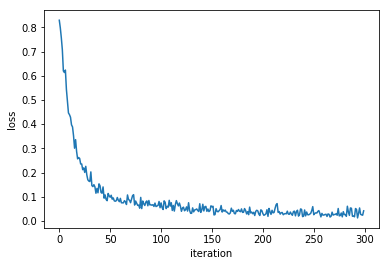

In [0]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

#### 6.3 : Visualizing the misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample : 195; Expected Label: tensor([0]); Obtained Label: tensor([1])


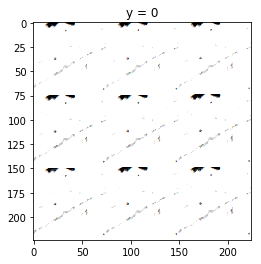

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample : 204; Expected Label: tensor([1]); Obtained Label: tensor([0])


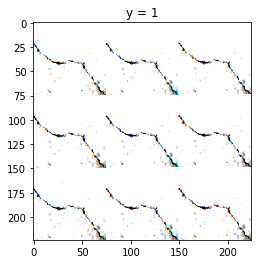

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample : 280; Expected Label: tensor([1]); Obtained Label: tensor([0])


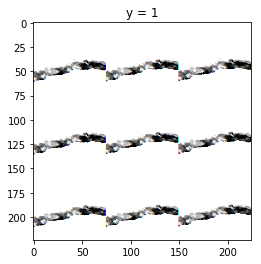

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample : 386; Expected Label: tensor([1]); Obtained Label: tensor([0])


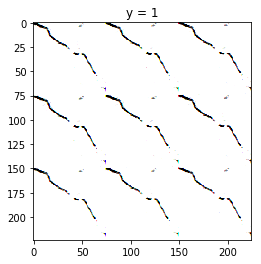

In [0]:
count=0
validation = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)
for i, (x_test, y_test) in enumerate(validation):
    z = model(x_test) 
    _, yhat = torch.max(z.data, 1)
    if yhat != y_test:
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        visualize((x_test,y_test))
        plt.show()
        count=count+1
        if count>=4:
            break
        